In [26]:
from motif_addition import add_motifs
import scipy.stats as stats
import numpy as np
import pandas as pd

tsv_file = "/Users/wejarrard/projects/tf-binding/data/data_splits/validation_combined_no_motifs.csv"            # The TSV file with regions
reference_genome = "/Users/wejarrard/projects/tf-binding/data/genome.fa"      # The reference genome file (FASTA format)
jaspar_file = "/Users/wejarrard/projects/tf-binding/src/inference/motif_finding/motif.jaspar"      # The motif file (JASPAR format)
output_file = "./validation_combined.csv"  # Output TSV file with motif column
# df = add_motifs(tsv_file, jaspar_file, reference_genome, output_file, percentile_cutoff=0) 
all_motifs_df, best_motifs_df, top10_motifs_df = add_motifs(tsv_file, jaspar_file, reference_genome, output_file, min_score=-10, top_n=2)

2024-10-23 17:41:14,634 - INFO - Reading motif from JASPAR file: /Users/wejarrard/projects/tf-binding/src/inference/motif_finding/motif.jaspar
2024-10-23 17:41:14,638 - INFO - Motif length: 15
2024-10-23 17:41:14,640 - INFO - Opening reference genome FASTA file: /Users/wejarrard/projects/tf-binding/data/genome.fa
2024-10-23 17:41:14,645 - INFO - Reading input TSV file: /Users/wejarrard/projects/tf-binding/data/data_splits/validation_combined_no_motifs.csv
2024-10-23 17:41:14,693 - INFO - Starting motif processing...
Processing motifs: 100%|██████████| 103209/103209 [00:37<00:00, 2752.30it/s]
2024-10-23 17:41:57,628 - INFO - Percentile threshold (0%): -10.0
2024-10-23 17:42:06,168 - INFO - All motifs saved to: ./validation_combined.csv
2024-10-23 17:42:06,169 - INFO - Best motifs saved to: ./validation_combined.csv_best_motifs.tsv
2024-10-23 17:42:06,169 - INFO - Top 10 motifs saved to: ./validation_combined.csv_top10_motifs.tsv


In [27]:
# aggregate the top 10 motifs
top10_motifs_df['motif_score'] = top10_motifs_df['motif_score'].astype(str)
top10_motifs_df_agg = top10_motifs_df.groupby(['chr', 'start', 'end', 'count', 'label', 'cell_line']).agg({'motif_sequence': ','.join, 'motif_score': ','.join}).reset_index()

# compare len of motif sequences (number of motifs in it) between 1 and 0 labels if no_motif its a 0
top10_motifs_df_agg['motif_count'] = top10_motifs_df_agg['motif_sequence'].apply(lambda x: len(x.split(',')) if x != 'no_motif' else 0)
top10_motifs_df_agg

# compare motif count between 1 and 0 labels
print(top10_motifs_df_agg[top10_motifs_df_agg['label'] == 1]['motif_count'].mean())
print(top10_motifs_df_agg[top10_motifs_df_agg['label'] == 0]['motif_count'].mean())


1.9923134608173978
1.9995095785440613


Number of NAs in motif_score: 0
Mann-Whitney U test statistic: nan
p-value: nan

Mean motif score for label 1: 5.7245
Mean motif score for label 0: 6.8972


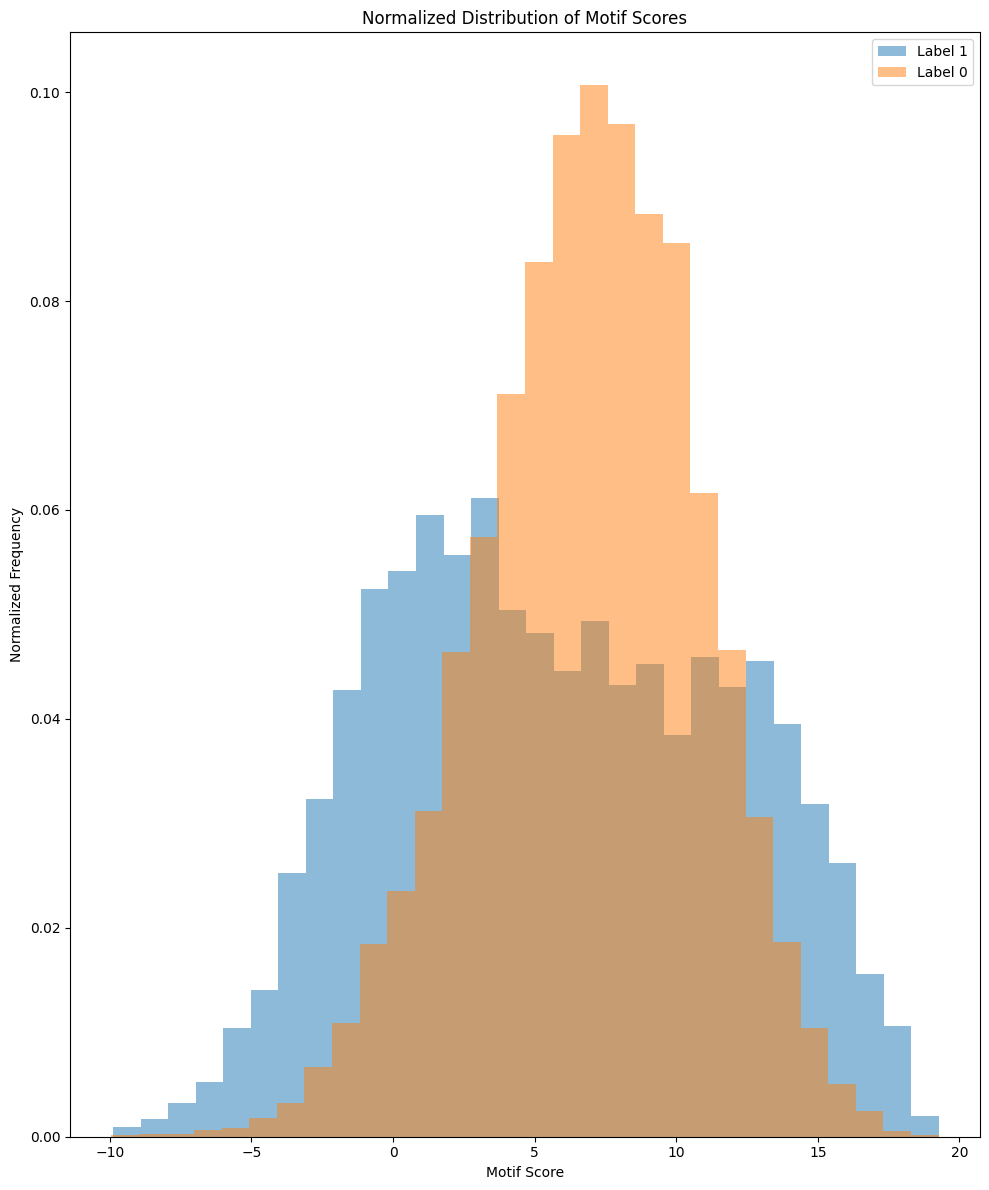

In [30]:
df = top10_motifs_df
# drop nas
# count nas
print("Number of NAs in motif_score:", df['motif_score'].isna().sum())

df = df.dropna()
# get distribution of motif scores label 1 vs label 0
df['motif_score'].value_counts()

# Separate the data into two groups based on the label
label_1 = df[df['label'] == 1]['motif_score']
label_0 = df[df['label'] == 0]['motif_score']

# Remove 'NaN' values and convert to numeric
label_1 = pd.to_numeric(label_1[label_1 != 'NA'], errors='coerce')
label_0 = pd.to_numeric(label_0[label_0 != 'NA'], errors='coerce')

# Perform a Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(label_1, label_0, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {statistic}")
print(f"p-value: {p_value}")

# Calculate and print the mean scores for each group
mean_score_label_1 = label_1.mean()
mean_score_label_0 = label_0.mean()

print(f"\nMean motif score for label 1: {mean_score_label_1:.4f}")
print(f"Mean motif score for label 0: {mean_score_label_0:.4f}")

# Calculate and print the frequency of motifs for each group
# motif_freq_label_1 = (df[df['label'] == 1]['motif_sequence'] != 'no_motif').mean()
# motif_freq_label_0 = (df[df['label'] == 0]['motif_sequence'] != 'no_motif').mean()

# print(f"\nFrequency of motifs for label 1: {motif_freq_label_1:.4f}")
# print(f"Frequency of motifs for label 0: {motif_freq_label_0:.4f}")
# Visualize the distribution of motif scores
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax2) = plt.subplots(1, 1, figsize=(10, 12))

# Plot normalized histograms
weights_1 = np.ones_like(label_1) / len(label_1)
weights_0 = np.ones_like(label_0) / len(label_0)

# Plot non-normalized histograms
# ax1.hist(label_1, bins=30, alpha=0.5, label='Label 1')
# ax1.hist(label_0, bins=30, alpha=0.5, label='Label 0')
# ax1.set_xlabel('Motif Score')
# ax1.set_ylabel('Frequency')
# ax1.set_title('Non-Normalized Distribution of Motif Scores')
# ax1.legend()

ax2.hist(label_1, bins=30, alpha=0.5, label='Label 1', weights=weights_1)
ax2.hist(label_0, bins=30, alpha=0.5, label='Label 0', weights=weights_0)
ax2.set_xlabel('Motif Score')
ax2.set_ylabel('Normalized Frequency')
ax2.set_title('Normalized Distribution of Motif Scores')
ax2.legend()



plt.tight_layout()
plt.show()


In [31]:
# get the motifs with a score greater than 15
df[df['motif_score'] > 13]['motif_sequence'].value_counts()

TypeError: '>' not supported between instances of 'str' and 'int'

In [35]:
df[df['label'] == 1]['motif_sequence'].value_counts()


motif_sequence
AGGAACAGTCAGCAG    20
GAGTAAACAGACAAC    13
ATGGAATGGAATGGA     6
TAGCCCTAAATCCAT     5
GAGGAGATCAAGACC     5
                   ..
CTTTCTCAAACAAAA     1
CCGACCCAATTAAAT     1
AAGGACATTTGGTAC     1
GTATGAAAAGGTTTT     1
TGGAAAGCAATGGAC     1
Name: count, Length: 5165, dtype: int64

In [36]:
# see what motifs differ most in count between label 1 and label 0
df[df['motif_sequence'] != 'no_motif']['motif_sequence'].value_counts()
df[df['label'] == 1]['motif_sequence'].value_counts()
df[df['label'] == 0]['motif_sequence'].value_counts()

# see what the biggest differences 

motif_sequence
GGGAACTCCCTGACC    672
CCCTTGCGCTTCCCA    352
TGCCTCCTCAAGTGG    120
CCCTTGCGCTTCCCG     79
CAGCACTCTGTGTCT     69
                  ... 
AGGAACTTACAGTTC      1
GAGAACTTTTGGTAC      1
AAAATATTTGACTGT      1
GGGCACAGTGGGAAA      1
TGGAACTGAATGGAC      1
Name: count, Length: 89122, dtype: int64